## 1. Import libraries and sample dataset

- Episode starts with taxi at a random square and passenger at random location, and ends with the passenger being dropped off at a specified destination.
- 4 destinations: R(ed), G(reen), Y(ellow), and B(lue)

There are `500` discrete states as `25` (taxi positions) × `5` (possible passenger locations) × `4` (destination).

| Location index | Description |
| -- | --- |
| `0` | R(ed) |
| `1` | G(reen) |
| `2` | Y(ellow) |
| `3` | B(lue) |
| `4` | In taxi |

There are `6` discrete deterministic actions:

| Action index | Description |
| -- | -- |
| `0` | move south |
| `1` | move north |
| `2` | move east |
| `3` | move west |
| `4` | pickup passenger |
| `5` | drop off passenger |

The reward functions acts like this:

| Reward value | Description |
| -- | -- |
| `-1` | Per step reward |
| `+20` | Delivering passenger |
| `-10` | Executing "pickup" or "drop-off" actions illegally |

### Rendering

These are the color indications,

| Color | Description |
| -- | -- |
| Blue | Passenger |
| Magenta | Destination |
| Yellow | Empty taxi |
| Green | Full taxi |

These are the letter indications,

| Letter | Description |
| -- | -- |
| R | R(ed) destination |
| G | G(reen) destination |
| Y | Y(ellow) destination |
| B | B(lue) destination |

The block represent the taxi.

In [1]:
import gym
import numpy as np
import pandas as pd

streets = gym.make("Taxi-v3").env
streets.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



## 2. Find optimized `π(s|a)` and `v(s)` from Value Iteration

Credits to [angps95@kaggle](https://www.kaggle.com/angps95/intro-to-reinforcement-learning-with-openai-gym/).

In [2]:
"""
Where Δ is delta of change, and Θ is acceptable threshold,

1. Set Θ
2. Set Δ = 0
3. Start with V = [0, ..., 0]
4. For each s ∈ S,
    a. Find max{Q(s, a ∈ A)}
    b. Set Δ = max(Δ, |Q_max - V[s]|)
    c. V[s] = Q_max
5. If Θ < Δ, repeat 4
6. Return π(s|a) and V(s)

Useful equations,
Q*(s, a) = ρ(s,s')^a * [R(s, a, s') + γ * V*(s')]
V*(s) = argmax(a ∈ A)(Q*(s, a))
"""
discount_factor = 0.99
theta = 0.00001

no_of_states = streets.observation_space.n
no_of_actions = streets.action_space.n
no_of_iter = 0

V = np.zeros(no_of_states)
             

def opt_Q(state):
    Q = np.zeros(no_of_actions)

    for action in range(no_of_actions):
        for trans_prob, next_state, reward, _ in streets.P[state][action]:
            Q[action] += trans_prob * reward + discount_factor * V[next_state] 

    return Q


while True:
    delta = 0

    for state in range(no_of_states):
        Q_max = np.max(opt_Q(state))
        delta = max(delta, np.abs(Q_max - V[state]))
        V[state] = Q_max
        
    no_of_iter += 1

    if delta < theta:
        break

policy = np.zeros([no_of_states, no_of_actions])

# Set the best action to 1 to make it deterministic policy (returns 0 or 1 to act upon).
for state in range(no_of_states):
    best_action = np.argmax(opt_Q(state))
    policy[state][best_action] = 1

print(f'Completed with {no_of_iter} iterations')

Completed with 725 iterations


## 3. Find the amount of steps taken upon using model algorithm

Reset the environment after having pre-learnt it and find the amount of steps taken to reach goal.

In [3]:
def episode_steps():
    current_state = streets.reset()
    reward = 0
    no_of_steps = 0

    while reward != 20:
        state, reward, _, _ = streets.step(np.argmax(policy[current_state]))  
        current_state = state
        no_of_steps += 1
    
    return no_of_steps

episode_dist = np.array([episode_steps() for i in range(10000)])

## 4. Display episode steps distribution

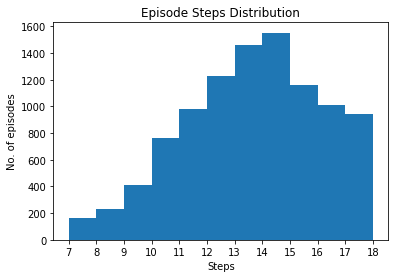

In [4]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,1)
bins = [i + 1 for i in range(np.min(episode_dist), np.max(episode_dist))]

ax.hist(episode_dist, bins=bins)
ax.set_title("Episode Steps Distribution")
ax.set_xticks(bins)
ax.set_xlabel('Steps')
ax.set_ylabel('No. of episodes')
plt.show()